In [5]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [12]:
headers = {'X-App-Token': 'b0nu5h6f5RSJRNPajPuuCf7wo'}

In [46]:
resources = ['q39e-7gbs', '5gde-fmj3', 'rgfe-8y2z', 'jzst-u7j8', 'hypw-js3b', '8u86-bviy', 'n2mv-q2ia', 'vdzd-yy49', 'qb3v-bbre']
years = np.arange(2011, 2019)

benchmark = []
for resource, year in zip(resources, years):
    offset = 0
    print(f'getting {year} data')
    while offset >= 0:
        url = f'https://data.cityofnewyork.us/resource/{resource}.json?$offset={offset}'
        json = requests.get(url, headers=headers).json()
        if len(json) == 0:
            offset = -1
        else:
            data = pd.DataFrame(json)
            data['year'] = year
            benchmark.append(data)
            offset += 1000

benchmark = pd.concat(benchmark)
print('done')

getting 2011 data
getting 2012 data
getting 2013 data
getting 2014 data
getting 2015 data
getting 2016 data
getting 2017 data
getting 2018 data


In [47]:
benchmark.to_pickle('benchmark.pkl')

In [71]:
dates = ['filing_date', 'issuance_date']

permit = []
offset = 0
while offset >= 0:
    url = (
        'https://data.cityofnewyork.us/resource/ipu4-2q9a.json?'
        '$where=issuance_date > "2011-01-01T00:00"'
        '&permit_type=NB'
        '&filing_status=INITIAL'
        f'&$offset={offset}'
    )
    json = requests.get(url, headers=headers).json()
    if len(json) == 0:
        offset = -1
    else:
        data = pd.DataFrame(json)
        data[dates] = data[dates].apply(pd.to_datetime)
        bo = data['job__'].astype('string').str[0]
        bl = data['block'].astype('string').str.pad(5, fillchar='0')
        lo = data['lot'].astype('string').str.pad(4, fillchar='0')
        data['bbl'] = bo.str.cat(bl.str.cat(lo))
        permit.append(data)
        offset += 1000

permit = pd.concat(permit)
print('done')

done


In [72]:
permit.to_pickle('permit.pkl')

In [2]:
# benchmark = pd.read_pickle('benchmark.pkl')
# permit = pd.read_pickle('permit.pkl')

In [3]:
benchmark.rename(columns={'nyc_building_identification': 'bin__'}, inplace=True)
benchmark.sort_values(['bin__', 'year'], ascending=False)
build = permit.merge(benchmark.drop_duplicates('bin__'), on='bin__')
build.shape

(692, 191)

<AxesSubplot:xlabel='energy_star_score', ylabel='filing_days'>

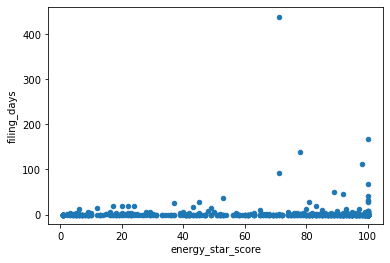

In [9]:
build['filing_days'] = (build['issuance_date'] - build['filing_date']).dt.days
build['energy_star_score'] = pd.to_numeric(build['energy_star_score'], 'coerce')

fig, ax = plt.subplots()
build.plot('energy_star_score', 'filing_days', kind='scatter', ax=ax)